In [1]:
import numpy as np
import pandas as pd
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import math
import os
import glob

nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from heapq import nlargest
# from pmaw import PushshiftAPI

# Instantiate Pushshift API
# api = PushshiftAPI(num_workers=20)

sid = SentimentIntensityAnalyzer()
lemma = WordNetLemmatizer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/rohin/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /home/rohin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/rohin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/rohin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/rohin/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /home/rohin/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
years = [2017, 2018, 2019, 2020, 2021]

public_subreddits = ["UCSD", "FSU", "ucla", "UCSantaBarbara", "UCI", "UCDavis", "UCSC", "uofm", "udub", "UTAustin",
                     "PennStateUniversity", "gatech"]
private_subreddits = ["georgetown", "BrownU", "Harvard","UPenn","USC","Syracuse","columbia","mit","notredame",
                      "stanford","yale","BostonU"]

In [3]:
# Modify the data frame to include sentiment score. Sentiment is calculated on the combined title and body.
def get_sentiment(filepath):
    df = pd.read_csv(filepath)
    
    df["full_text"] = df["title"] + " " + df["selftext"] # concatenate title and body
    df["sent_score"] = df["full_text"].apply(lambda review: sid.polarity_scores(review)) # get scores
    df["compound"] = df["sent_score"].apply(lambda score_dict: score_dict["compound"]) # get compound score
    df["sentiment"] = df["compound"].apply(lambda c: "pos" if c > 0 else ("neu" if c == 0 else "neg")) # get overall sentiment
    
    return df

In [4]:
def sentiment_to_dict(college_type, college_list):
    unis = {}
    
    for subreddit in college_list:
        datadir = "data/" + college_type + "/" + subreddit + "/" + subreddit + "_all_time.csv"
        df = get_sentiment(datadir)

        unis[subreddit] = df
        
    return unis

In [5]:
public_unis = sentiment_to_dict("public", public_subreddits)
private_unis = sentiment_to_dict("private", private_subreddits)

In [6]:
stop_words = list(stopwords.words('english'))

# Add more common stop words
stop_words = stop_words + ["'m", "n't", "'s", "'re", "'ve", "could", "should", 
                           "would", "though", "http", "https", "www", "also"]

print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [7]:
# Convert each nltk POS tag to wordnet format
def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:         
        return None

In [8]:
# Given a list of tuples in the form (word, tag), return the lemmatized sentence
def lemmatize_sentence(tagged_list):
    sentence = []
    
    for word, tag in tagged_list:
        if tag is None:
            # If there is no available tag, append the word as is
            sentence.append(word)
        else:       
            # Else, use the tag to lemmatize the token
            sentence.append(lemma.lemmatize(word, tag))
    
    return sentence

In [9]:
# Get word frequency given a DataFrame
def get_word_frequency(df):
    df["text_token"] = df["full_text"].str.lower().apply(word_tokenize) # tokenize (lowercase) text
    df["text_stop"] = df["text_token"].apply(lambda x: [word for word in x if word not in stop_words]) # remove stop words
    
    df["text_lemma"] = df["text_stop"].apply(lambda x: nltk.pos_tag(x)) # get the part of speech (POS) tag for each word
    df["text_lemma"] = df["text_lemma"].apply(lambda x: [(tup[0], pos_tagger(tup[1])) for tup in x]) # convert tag to wordnet format
    df["text_lemma"] = df["text_lemma"].apply(lambda x: lemmatize_sentence(x)) # lemmatize
    
    text = df["text_lemma"].apply(pd.Series).stack()
    
    fdist = FreqDist(text)
    
    # Delete punctuation
    for punc in string.punctuation:
        del fdist[punc]
    
    # Manually delete any other common punctuation or stop words that remain
    other = ["’", "''", "--", "``", "//", "”", "“", "...", "–"]
    
    for item in other:
        del fdist[item]
        
    return fdist

In [11]:
def get_top_words(college_dict):
    topwords = {}

    # Get the top 50 most frequent words (after filtering) from the csv data
    for subreddit, df in college_dict.items():
        freq = get_word_frequency(df)
        top = nlargest(50, freq, key = freq.get)
        topwords[subreddit] = top
    
    return topwords

In [12]:
def get_sentiment_per_word(word_dict, college_dict):
    for subreddit, words in word_dict.items():
        # Initialize each list of top words to a dictionary
        word_dict[subreddit] = {word: None for word in words} 

        sentiment = 0
        count = 0

        df = college_dict[subreddit]

        for word in words:
            for ind in df.index:
                if word in df["full_text"][ind]:
                    sentiment += df["compound"][ind]
                    count += 1

            av = sentiment/count

            word_dict[subreddit][word] = av
            
    return word_dict

In [13]:
public_words = get_top_words(public_unis)
public_word_sentiment = get_sentiment_per_word(public_words, public_unis)

private_words = get_top_words(private_unis)
private_word_sentiment = get_sentiment_per_word(private_words, private_unis)

In [14]:
def sentiment_vs_word(word_dict, subreddit_list):
    fig, ax = plt.subplots(nrows=6, ncols=2, figsize=(16,18))
    
    count = 0
    for i in range(0,6):
        for j in range(0,2):
            
            subreddit = subreddit_list[count]

            df = pd.DataFrame(word_dict[subreddit].values(), index = word_dict[subreddit].keys())
            df.columns = ["score"]

            sns.barplot(x=df.index, y="score", data=df, ax=ax[i,j]);
            ax[i,j].set_title(subreddit)
            ax[i,j].set_xticklabels(ax[i,j].get_xticklabels(), rotation = 90, fontsize=9)
            
            count += 1
    
    plt.tight_layout()

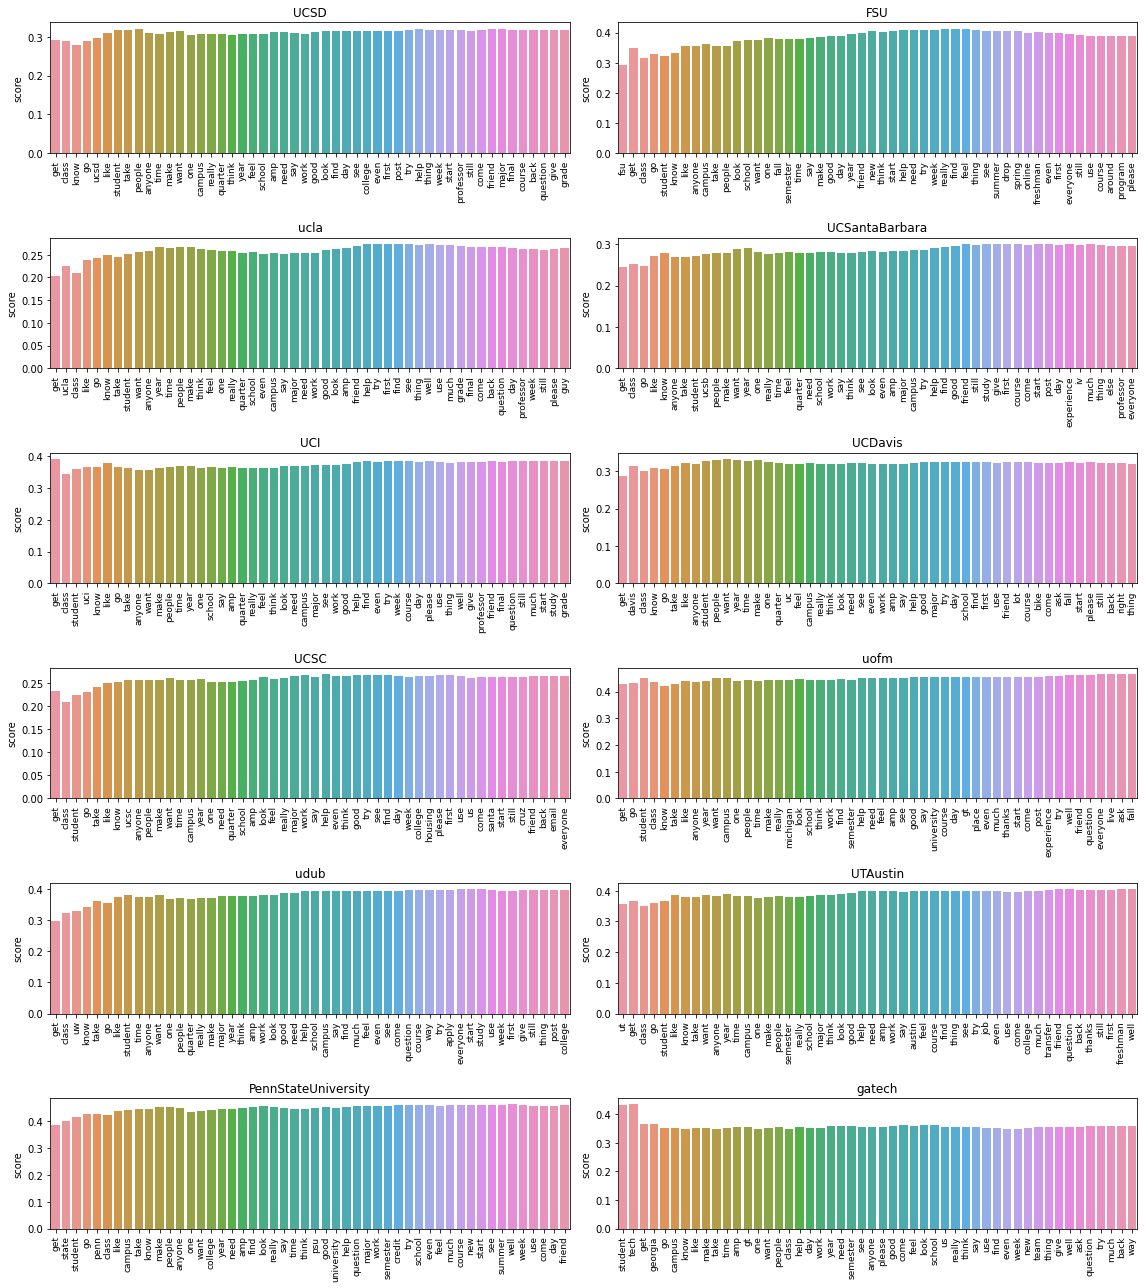

In [15]:
sentiment_vs_word(public_words, public_subreddits)

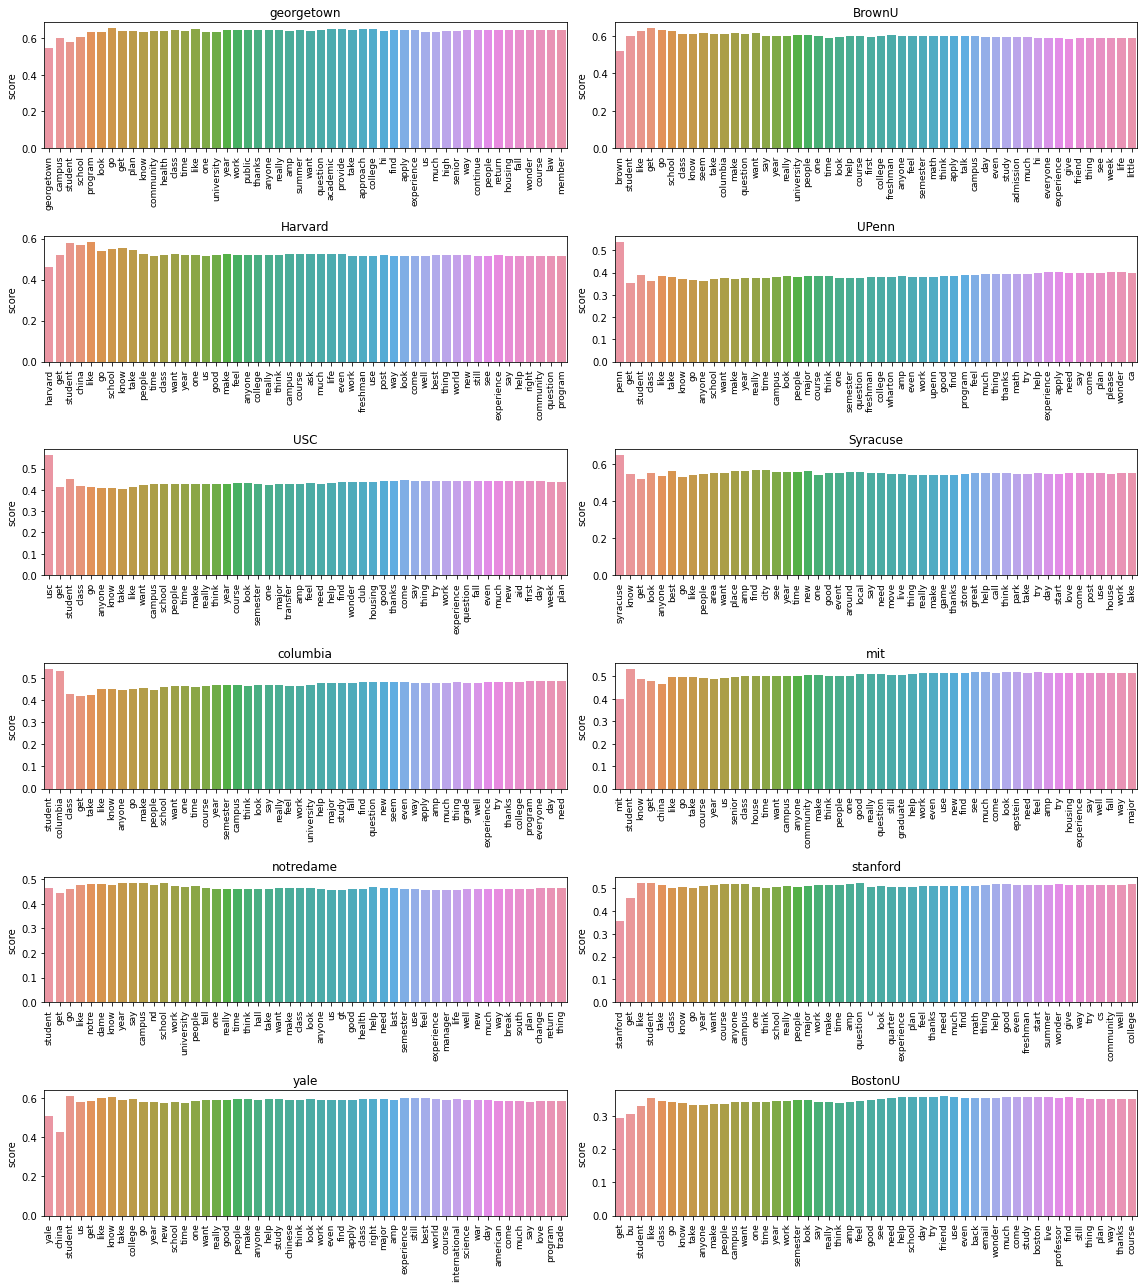

In [16]:
sentiment_vs_word(private_words, private_subreddits)